In [1]:
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from Data_Load_Assign_Visual import *
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

# Set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

| using device: cuda


In [3]:
# Load Dataset
train_data, test_data = load_MNIST()

# print("Type of trainDataset：", type(train_data))
# print("Length of trainDataset：", len(train_data))

# print("Type of trainDataset[0]：", type(train_data[0]))
# print("Length of trainDataset[0]：", len(train_data[0]))

# print("Type of trainDataset[0][0]：", type(train_data[0][0]))
# print("Shape of trainDataset[0][0]：", train_data[0][0].shape)
# print("Type of trainDataset[0][1]：", type(train_data[0][1]))
# print("trainDataset[0][1]：", train_data[0][1])

# Get client dataloaders
iid_train_loader = iid_Assign(train_data)
noniid_train_loader = non_iid_Assign(train_data)
# print("iid_train_loader length", len(iid_train_loader))
# print("noniid_train_loader length", len(noniid_train_loader))

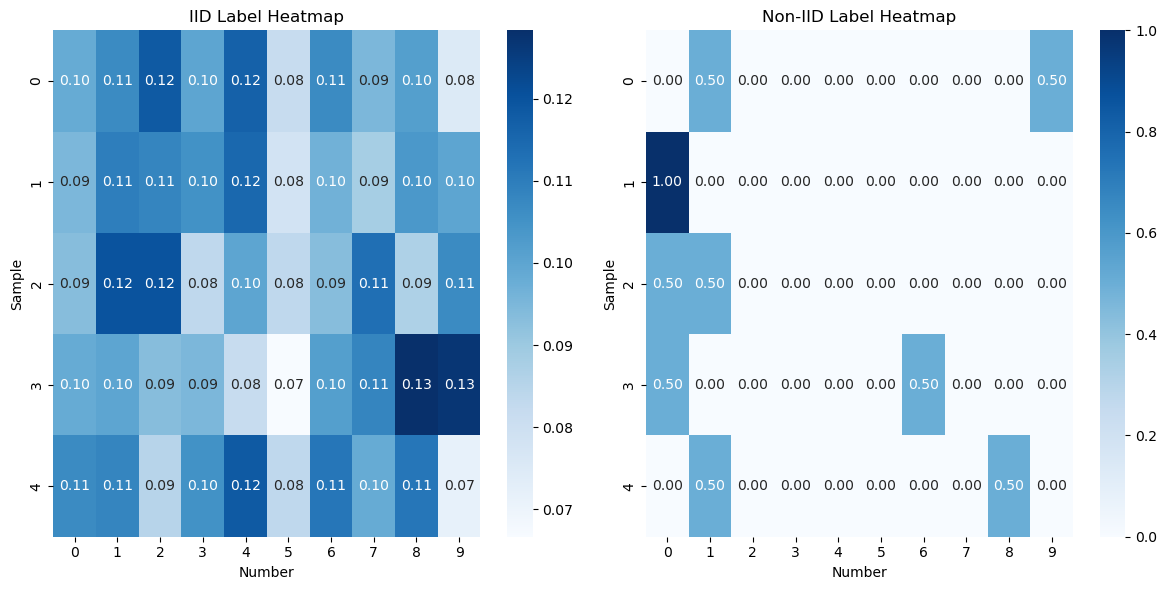

In [4]:
# Test iid and non-iid is correct.

# iid
sample_iid = random.sample(iid_train_loader, 5)
iid_labels = []
for i in sample_iid:
    iid_label = torch.zeros(10)
    for (x,y) in i:
        iid_label += torch.sum(F.one_hot(y, num_classes=10), dim=0)
    iid_labels.append(iid_label)
    
iid_labels = torch.stack(iid_labels)
iid_normalized = iid_labels / 600 # min-max normalization

# non_iid
sample_noniid = random.sample(noniid_train_loader, 5)
noniid_labels = []
for i in sample_noniid:
    noniid_label = torch.zeros(10)
    for (x,y) in i:
        noniid_label += torch.sum(F.one_hot(y, num_classes=10), dim=0)
    noniid_labels.append(noniid_label)
    
noniid_labels = torch.stack(noniid_labels)
noniid_normalized = noniid_labels / 600

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(iid_normalized.numpy(), cmap='Blues', annot=True, fmt=".2f", cbar=True)
plt.xlabel('Number')
plt.ylabel('Sample')
plt.title('IID Label Heatmap')

plt.subplot(1, 2, 2)
sns.heatmap(noniid_normalized.numpy(), cmap='Blues', annot=True, fmt=".2f", cbar=True)
plt.xlabel('Number')
plt.ylabel('Sample')
plt.title('Non-IID Label Heatmap')

plt.tight_layout()
plt.show()

In [5]:
# Model Defination

# Model 1: A simple multilayer-perceptron with 2-hidden
# layers with 200 units each using ReLu activations (199,210
# total parameters), which we refer to as the MNIST 2NN.

# define fully connected NN
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # torch.Size([B,784])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

print(MLP())
print("Total parameters of 2NN(MLP) is", num_params(MLP()))

# Model 2: A CNN with two 5x5 convolution layers (the first with
# 32 channels, the second with 64, each followed with 2x2
# max pooling), a fully connected layer with 512 units and
# ReLu activation, and a final softmax output layer (1,663,370
# total parameters).

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print("After x = F.relu(self.conv1(x)), the shape of x is: ", x.shape)
        x = self.pool1(x)
        # print("After x = self.pool1(x), the shape of x is: ", x.shape)
        x = F.relu(self.conv2(x))
        # print("After x = F.relu(self.conv2(x)), the shape of x is: ", x.shape)    
        x = self.pool2(x)
        # print("After x = self.pool1(F.relu(self.conv1(x))), the shape of x is: ", x.shape)
        
        x = x.view(-1, 64 * 7 * 7) # flatten
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

print(CNN())
print("Total parameters of CNN is", num_params(CNN()))

# Q: The paper said there will be 1,663,370 total parameters. Something wrong?

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
Total parameters of 2NN(MLP) is 199210
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Total parameters of CNN is 1663370


In [6]:
# Fed_Avg
def fedavg(global_model, C, K, E, c_loader, rounds, lr, acc_threshold):
    # C is the fraction of clients that perform computation on each round.
    assert C <= 1 and C >= 0
    # K is the number of clients.
    # E is the local epochs, the number of training passes each client makes
    # over its local dataset on each round.
    
    c_per_round = max( round(C * K), 1)
    accuracy = []
    entropys_of_rounds = []
    
    for rd in range(rounds):
        
        # Choose c_per_round clients
        clients = random.sample(range(K), c_per_round)
        
        # Train on clients one by one
        client_model = []
        entropys_of_clients = []
        for i, c in enumerate(clients):
            local_model, entropy = client_training(global_model, id = c, local_epochs = E, dataloader = c_loader[c], lr = lr)
            local_model = local_model.to(device)
            client_model.append(local_model.state_dict())
            entropys_of_clients.append(entropy)
        
        entropys_of_rounds.append(entropys_of_clients)
    
        # Average and iterate global model parameters for next round  
        keys = client_model[0].keys()
        next_global_dict = {key: 0 for key in keys}
        for key in keys:
            values = [d[key] for d in client_model]
            averaged_value = sum(values) / len(values)
            next_global_dict[key] = averaged_value
            
        global_model.load_state_dict(next_global_dict)
        global_model = global_model.to(device)
        
        # Validate accuracy this round
        test_inputs, test_labels = zip(*test_data)
        test_inputs = torch.stack(test_inputs).to(device)
        test_labels = torch.Tensor(test_labels).to(device)

        global_model.eval()
        with torch.no_grad():
            predictions = global_model(test_inputs)

        predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
        true_labels = test_labels.cpu().numpy()

        acc = accuracy_score(true_labels, predicted_labels)
        if rd%10 == 0 or acc >= acc_threshold:
            print("The clients in round {} are: {}".format(rd, clients))
            print("Accuracy of round {}:{}".format(rd, acc))
            print()
        accuracy.append(acc)
        if acc >= acc_threshold:
            break
        
    return accuracy, entropys_of_rounds

Choose entropy for uncertainty estimation:
$$\mathbb{H}[y|\mathbf{x},\mathcal{D}_{train}]:=-\sum_{c}p(y=c|\mathbf{x},\mathcal{D}_{train})\log p(y=c|\mathbf{x},\mathcal{D}_{train})$$

In [7]:
# Calculate the averaged entropy of the local model after every local training
def calculate_entropy(logits):
    log_probabilities = torch.log2(logits)
    entropy = -torch.sum(logits * log_probabilities, dim=1)
    return entropy.mean().item()

In [8]:
criterion = nn.CrossEntropyLoss()

def client_training(global_model, id, local_epochs, dataloader, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)
    
    for epoch in range(local_epochs):
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # Calculate the Averaged Entropy After All Epoches:
        if epoch == local_epochs - 1:
            with torch.no_grad():
                outputs = local_model(inputs)
                entropy = calculate_entropy(outputs)            
            
    return local_model, entropy

# MNIST 2NN 

In [ ]:
mlp = MLP()
acc_threshold_2nn = 0.97

In [ ]:
# iid C = 0.1
mlp_iid1 = copy.deepcopy(mlp)
acc_mlp_iid1 = fedavg(mlp_iid1, C = 0.1, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_iid1, acc_threshold_2nn, 'iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid1), acc_mlp_iid1[-1]))

In [ ]:
# iid C = 0.2
mlp_iid2 = copy.deepcopy(mlp)
acc_mlp_iid2 = fedavg(mlp_iid2, C = 0.2, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_iid2, acc_threshold_2nn, 'iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid2), acc_mlp_iid2[-1]))

In [ ]:
# iid C = 0.5
mlp_iid3 = copy.deepcopy(mlp)
acc_mlp_iid3 = fedavg(mlp_iid3, C = 0.5, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_iid3, acc_threshold_2nn, 'iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid3), acc_mlp_iid3[-1]))

In [ ]:
# iid C = 1
mlp_iid4 = copy.deepcopy(mlp)
acc_mlp_iid4 = fedavg(mlp_iid4, C = 1, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_iid4, acc_threshold_2nn, 'iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid4), acc_mlp_iid4[-1]))

In [ ]:
# non-iid C = 0.1
mlp_noniid1 = copy.deepcopy(mlp)
acc_mlp_noniid1 = fedavg(mlp_noniid1, C = 0.1, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_noniid1, acc_threshold_2nn, 'non-iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid1), acc_mlp_noniid1[-1]))

In [ ]:
# non-iid C = 0.2
mlp_noniid2 = copy.deepcopy(mlp)
acc_mlp_noniid2 = fedavg(mlp_noniid2, C = 0.2, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_noniid2, acc_threshold_2nn, 'non-iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid2), acc_mlp_noniid2[-1]))

In [ ]:
# non-iid C = 0.5
mlp_noniid3 = copy.deepcopy(mlp)
acc_mlp_noniid3 = fedavg(mlp_noniid3, C = 0.5, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_noniid3, acc_threshold_2nn, 'non-iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid3), acc_mlp_noniid3[-1]))

In [ ]:
# non-iid C = 1
mlp_noniid4 = copy.deepcopy(mlp)
acc_mlp_noniid4 = fedavg(mlp_noniid4, C = 1, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)
pltAcc(acc_mlp_noniid4, acc_threshold_2nn, 'non-iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid4), acc_mlp_noniid4[-1]))

In [ ]:
plt.figure(figsize=(12, 8))
log_rounds = np.log10(range(50, 500, 100))
rounds = range(50, 500, 100) 

plt.plot(np.log10(range(1, len(acc_mlp_iid1) + 1)), acc_mlp_iid1, marker='.', linestyle='solid', color='blue', label='iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_mlp_iid2) + 1)), acc_mlp_iid2, marker='.', linestyle='solid', color='green', label='iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_mlp_iid3) + 1)), acc_mlp_iid3, marker='.', linestyle='solid', color='red', label='iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_mlp_iid4) + 1)), acc_mlp_iid4, marker='.', linestyle='solid', color='purple', label='iid, C = 1')
plt.plot(np.log10(range(1, len(acc_mlp_noniid1) + 1)), acc_mlp_noniid1, marker='.', linestyle='dotted', color='orange', label='non-iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_mlp_noniid2) + 1)), acc_mlp_noniid2, marker='.', linestyle='dotted', color='cyan', label='non-iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_mlp_noniid3) + 1)), acc_mlp_noniid3, marker='.', linestyle='dotted', color='magenta', label='non-iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_mlp_noniid4) + 1)), acc_mlp_noniid4, marker='.', linestyle='dotted', color='brown', label='non-iid, C = 1')

plt.axhline(y=acc_threshold_2nn, color='gray', linestyle='solid')

plt.xlabel('Rounds')
plt.ylabel('Acc')

plt.title('Test set accuracy vs. communication rounds for MNIST 2NN')

plt.ylim(0.8, 1)
plt.xticks(log_rounds, rounds)

plt.legend()

plt.show()

# MNIST CNN

In [15]:
cnn = CNN()
acc_threshold_cnn = 0.99

In [16]:
# iid C = 0.1
cnn_iid1 = copy.deepcopy(cnn)
acc_cnn_iid1, entropy_cnn_iid1 = fedavg(cnn_iid1, C = 0.1, K = 100, E = 5, 
                      c_loader = iid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)

The clients in round 0 are: [26, 48, 75, 37, 1, 17, 19, 34, 42, 43]
Accuracy of round 0:0.196

The clients in round 10 are: [96, 86, 25, 15, 63, 50, 32, 26, 82, 5]
Accuracy of round 10:0.9629

The clients in round 20 are: [0, 94, 23, 38, 64, 72, 32, 42, 8, 63]
Accuracy of round 20:0.9725

The clients in round 30 are: [11, 99, 80, 64, 89, 67, 53, 39, 14, 18]
Accuracy of round 30:0.9779

The clients in round 40 are: [2, 50, 9, 89, 16, 53, 38, 70, 94, 18]
Accuracy of round 40:0.9813

The clients in round 50 are: [67, 74, 90, 50, 56, 13, 95, 32, 45, 36]
Accuracy of round 50:0.9826

The clients in round 60 are: [0, 34, 81, 89, 37, 93, 29, 18, 96, 73]
Accuracy of round 60:0.9838

The clients in round 70 are: [71, 28, 58, 24, 43, 77, 13, 10, 40, 41]
Accuracy of round 70:0.9855

The clients in round 80 are: [31, 27, 36, 94, 84, 0, 68, 65, 54, 6]
Accuracy of round 80:0.9864

The clients in round 90 are: [51, 90, 24, 40, 37, 49, 7, 26, 4, 92]
Accuracy of round 90:0.9875

The clients in round 100

In [33]:
def pltUncertainty(A, title):
    max_values = [np.max(a_i) for a_i in A]
    min_values = [np.min(a_i) for a_i in A]
    avg_values = [np.mean(a_i) for a_i in A]


    fig, ax = plt.subplots()

    ax.fill_between(np.log10(range(1, len(A) + 1)), min_values, max_values, facecolor='red', alpha=0.2)

    ax.plot(np.log10(range(1, len(A) + 1)), avg_values, color='blue')

    plt.ylim(-0.1, 1)
    plt.xticks(np.log10(range(20, 150, 40)), range(20, 150, 40))
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Uncertainty(Entropy)')
    ax.set_title(title)

    plt.show()

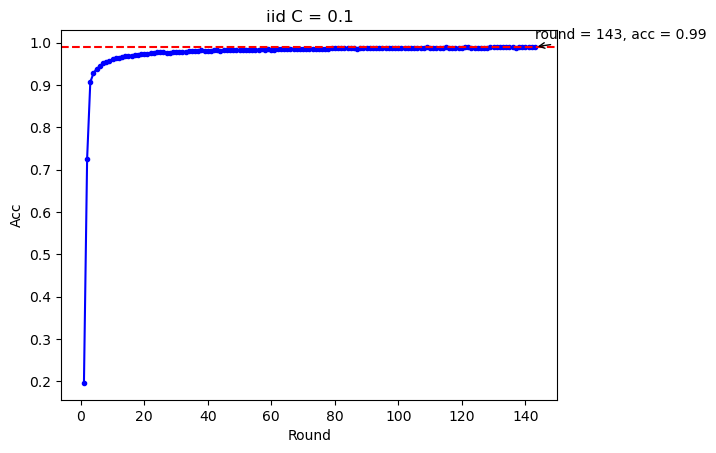

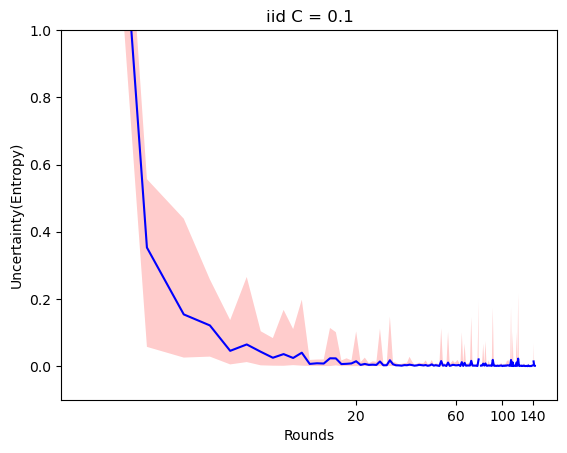

143 rounds needed to achieve the accuracy of 0.99


In [34]:
pltAcc(acc_cnn_iid1, acc_threshold_cnn, 'iid C = 0.1')
pltUncertainty(entropy_cnn_iid1, 'iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_iid1), acc_cnn_iid1[-1]))

In [ ]:
# iid C = 0.2
cnn_iid2 = copy.deepcopy(cnn)
acc_cnn_iid2, entropy_cnn_iid2 = fedavg(cnn_iid2, C = 0.2, K = 100, E = 5, 
                      c_loader = iid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)

In [ ]:
pltAcc(acc_cnn_iid2, acc_threshold_cnn, 'iid C = 0.2')
pltUncertainty(entropy_cnn_iid2, 'iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_iid2), acc_cnn_iid2[-1]))

In [ ]:
# iid C = 0.5
cnn_iid3 = copy.deepcopy(cnn)
acc_cnn_iid3 = fedavg(cnn_iid3, C = 0.5, K = 100, E = 5, 
                      c_loader = iid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_iid3, acc_threshold_cnn, 'iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_iid3), acc_cnn_iid3[-1]))

In [ ]:
# iid C = 1
cnn_iid4 = copy.deepcopy(cnn)
acc_cnn_iid4 = fedavg(cnn_iid4, C = 1, K = 100, E = 5, 
                      c_loader = iid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_iid4, acc_threshold_cnn, 'iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_iid4), acc_cnn_iid4[-1]))

In [ ]:
# non-iid C = 0.1
cnn_noniid1 = copy.deepcopy(cnn)
acc_cnn_noniid1 = fedavg(cnn_noniid1, C = 0.1, K = 100, E = 5, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_noniid1, acc_threshold_cnn, 'non-iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_noniid1), acc_cnn_noniid1[-1]))

In [ ]:
# non-iid C = 0.2
cnn_noniid2 = copy.deepcopy(cnn)
acc_cnn_noniid2 = fedavg(cnn_noniid2, C = 0.2, K = 100, E = 5, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_noniid2, acc_threshold_cnn, 'non-iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_noniid2), acc_cnn_noniid2[-1]))

In [ ]:
# non-iid C = 0.5
cnn_noniid3 = copy.deepcopy(cnn)
acc_cnn_noniid3 = fedavg(cnn_noniid3, C = 0.5, K = 100, E = 5, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_noniid3, acc_threshold_cnn, 'non-iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_noniid3), acc_cnn_noniid3[-1]))

In [ ]:
# non-iid C = 1
cnn_noniid4 = copy.deepcopy(cnn)
acc_cnn_noniid4 = fedavg(cnn_noniid4, C = 1, K = 100, E = 5, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_cnn)
pltAcc(acc_cnn_noniid4, acc_threshold_cnn, 'non-iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_cnn_noniid4), acc_cnn_noniid4[-1]))

In [ ]:
plt.figure(figsize=(12, 8))
log_rounds = np.log10(range(50, 500, 100))
rounds = range(50, 500, 100) 

plt.plot(np.log10(range(1, len(acc_cnn_iid1) + 1)), acc_cnn_iid1, marker='.', linestyle='solid', color='blue', label='iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_cnn_iid2) + 1)), acc_cnn_iid2, marker='.', linestyle='solid', color='green', label='iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_cnn_iid3) + 1)), acc_cnn_iid3, marker='.', linestyle='solid', color='red', label='iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_cnn_iid4) + 1)), acc_cnn_iid4, marker='.', linestyle='solid', color='purple', label='iid, C = 1')
plt.plot(np.log10(range(1, len(acc_cnn_noniid1) + 1)), acc_cnn_noniid1, marker='.', linestyle='dotted', color='orange', label='non-iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_cnn_noniid2) + 1)), acc_cnn_noniid2, marker='.', linestyle='dotted', color='cyan', label='non-iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_cnn_noniid3) + 1)), acc_cnn_noniid3, marker='.', linestyle='dotted', color='magenta', label='non-iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_cnn_noniid4) + 1)), acc_cnn_noniid4, marker='.', linestyle='dotted', color='brown', label='non-iid, C = 1')

plt.axhline(y=acc_threshold_cnn, color='gray', linestyle='solid')

plt.xlabel('Rounds')
plt.ylabel('Acc')

plt.title('Test set accuracy vs. communication rounds for MNIST CNN')

plt.ylim(0.8, 1)
plt.xticks(log_rounds, rounds)

plt.legend()

plt.show()